In [ ]:
import os
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGSMITH_PROJECT"] = "youtube-trail-1"
os.environ["LANGSMITH_ENDPOINT"] = ""
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] =""

In [270]:
import os
from langchain_openai import ChatOpenAI
from typing import Literal, Annotated
import sqlite3
import json
from datetime import datetime
from langchain_core.tools import tool
from langchain.chat_models import init_chat_model
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.types import Command
from tabulate import tabulate
from typing_extensions import TypedDict
from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt.chat_agent_executor import Prompt
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

In [272]:
def init_db(db_path: str = "theater.db") -> None:
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    cur.executescript("""
    CREATE TABLE screenings (
        screening_id INTEGER PRIMARY KEY,
        movie_title  TEXT NOT NULL,
        show_time    TEXT NOT NULL,
        available_seats INTEGER NOT NULL
    );
    CREATE TABLE bookings (
        booking_id   INTEGER PRIMARY KEY AUTOINCREMENT,
        screening_id INTEGER NOT NULL,
        customer_name TEXT NOT NULL,
        customer_phone TEXT NOT NULL,
        seats_booked  INTEGER NOT NULL,
        booking_time  TEXT NOT NULL,
        FOREIGN KEY(screening_id) REFERENCES screenings(screening_id)
    );
    """)
    # Insert sample screenings
    screenings = [
        (1, "The Matrix", "2025-05-11T19:00:00", 100),
        (2, "Inception", "2025-05-11T20:00:00", 80),
        (3, "Spirited Away", "2025-05-12T18:00:00", 50),
    ]
    cur.executemany(
        "INSERT INTO screenings(screening_id, movie_title, show_time, available_seats) VALUES (?,?,?,?)",
        screenings,
    )
    conn.commit()
    conn.close()

# Initialize DB on import
init_db()


### Test

In [274]:
conn = sqlite3.connect("theater.db")
cur = conn.cursor()
cur.execute("SELECT * FROM screenings")
authors = cur.fetchall()
authors

[(1, 'The Matrix', '2025-05-11T19:00:00', 100),
 (2, 'Inception', '2025-05-11T20:00:00', 80),
 (3, 'Spirited Away', '2025-05-12T18:00:00', 50)]

In [275]:

llm = ChatOpenAI(model_name="gpt-4", temperature=0)


In [276]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    query_type: Literal["book", "lookup"]
    customer_name: str | None
    customer_phone: str | None
    movie_title: str | None
    tickets: str | None
    llm_response: str | None


In [277]:
@tool
def check_seats_availability(
    movie_title: str,
    db_path: str = "theater.db"
) -> str:
    
    """Check the availability of seats for a given movie title."""
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    cur.execute(
        f"SELECT available_seats FROM screenings WHERE lower(movie_title) like '%{movie_title.lower()}%' "
    )
    row = cur.fetchone()
    conn.close()
    if row is None:
        return json.dumps({"error": f"{movie_title} not found."})
    return json.dumps({"available_seats": row[0]})


In [278]:
@tool
def _bookings(
    movie_title: str | None = None,
    customer_name: str = "",
    customer_phone: str = "",
    num_tickets: int = 0,
    db_path: str = "theater.db"
) -> str:
    """Book tickets for a given movie title."""
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    cur.execute(
        "SELECT screening_id, available_seats FROM screenings WHERE movie_title = ? ORDER BY show_time LIMIT 1",
        (movie_title,)
    )
    row = cur.fetchone()
    if not row:
        conn.close()
        return json.dumps({"error": "No upcoming screening found for given movie title."})
    
    screening_id, available = row
    # Check availability
    if num_tickets > available:
        conn.close()
        return json.dumps({"error": "Not enough seats available."})
    # Update availability
    new_avail = available - num_tickets
    cur.execute(
        "UPDATE screenings SET available_seats = ? WHERE screening_id = ?",
        (new_avail, screening_id)
    )
    # Insert booking record
    booking_time = datetime.now().isoformat()
    cur.execute(
        "INSERT INTO bookings(screening_id, customer_name, customer_phone, seats_booked, booking_time) VALUES (?,?,?,?,?)",
        (screening_id, customer_name, customer_phone, num_tickets, booking_time)
    )
    conn.commit()
    conn.close()
    screening_id, available = row
    return json.dumps({
        "screening_id": screening_id,
        "booked_seats": num_tickets,
        "remaining_seats": new_avail,
        "booking_time": booking_time
    })
    

In [222]:
gather_info_instructions = (
"""
    You are a movie theater assistant. Customers can ask for information about 
    1. movie ticket availability 
    2. book tickets.
    so, you are capable enough to understand the customer's request/query.
    if the customer is asking for information about ticket availability, respond with just TICKET_AVAILABILITY.
    if the customer is asking for booking tickets, respond with just BOOK_TICKETS.
    Do not respond with any other information or extra text, respond with just TICKET_AVAILABILITY or BOOK_TICKETS.
"""
)

In [280]:
def gather_info(state: State):
    res = llm.invoke([
        {"role": "system", "content": gather_info_instructions},
        *state["messages"],
    ])
    query_text = res.content
    print("query_text-->",query_text)
    if "TICKET_AVAILABILITY" in query_text:
        state['query_type'] = "lookup"
    elif "BOOK_TICKETS" in query_text:
        state['query_type'] = "book"
    else:
        raise ValueError(f"Unexpected response: {query_text}")
    # print("state-->",state)
    return state

In [281]:
def nav(state: State) -> Literal["lookup", "book", END]:
    if state['query_type'] == "lookup":
        return "lookup"
    elif state['query_type'] == "book":
        return "book"
    else:
        return END

In [282]:
def availability(state: State):
    # Create a React agent for availability
    prompt ="""you are a movie theater assistant.
    You are capable enough to understand the customer's request and check if the tickets are avaiable or not for the movie name provided by using the tools provided to you."""
    agent = create_react_agent(
        model=llm,
        tools=[check_seats_availability],
    )
    # print("state[messages][-1] ",state["messages"][-1])
    human_message =  state["messages"][-1].content
    # print("human_message-->",human_message)
    res = agent.invoke(
        {"messages": [{"role": "user", "content": f"{human_message}"}]}
    )
    # print("res-->",res['messages'][-1])
    return {'llm_response':res['messages'][-1].content}


In [283]:
def book(state: State):
    # Create a React agent for booking
    prompt = """you are a movie theater assistant.
    You are capable enough to understand the customer's request and book the tickets for the movie name provided by using the tools provided to you."""
    agent = create_react_agent(
        model=llm,
        tools=[_bookings],
    )
    # print("Book --> state[messages][-1] ",state["messages"][-1])
    human_message =  state["messages"][-1].content
    # print("Book --> human_message-->",human_message)
    # Invoke the agent with the state
    res = agent.invoke(
        {"messages": [{"role": "user", "content": f"{human_message}"}]}
    )
    # print("res-->",res['messages'][-1])
    return {'llm_response':res['messages'][-1].content}

In [284]:
graph_builder = StateGraph(State)
graph_builder.add_node("gather_info",gather_info)
graph_builder.add_node("availability",availability)
graph_builder.add_node("book",book)
graph_builder.add_edge(START, "gather_info")
graph_builder.add_conditional_edges(
    "gather_info",
    nav,
    {
        "lookup": "availability",
        "book": "book",
    },
)
graph_builder.add_edge("availability", END)
graph_builder.add_edge("book", END)
theater_graph = graph_builder.compile()

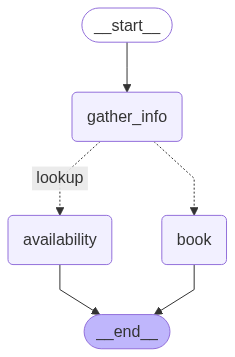

In [285]:
from IPython.display import Image, display

try:
    display(Image(theater_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [286]:
theater_graph.invoke(
        {"messages": [{"role": "user", "content": "Hi, could you tell me how many seats are available for The Matrix tonight?"}]}
    )

query_text--> TICKET_AVAILABILITY


{'messages': [HumanMessage(content='Hi, could you tell me how many seats are available for The Matrix tonight?', additional_kwargs={}, response_metadata={}, id='2d16f71d-aef0-4a97-b834-bb9d6b8a9819')],
 'query_type': 'lookup',
 'llm_response': 'There are 100 seats available for The Matrix tonight.'}

In [287]:
theater_graph.invoke(
        {"messages": [{"role": "user", "content": "Can you book 3 tickets to Inception"}]}
    )

query_text--> BOOK_TICKETS


{'messages': [HumanMessage(content='Can you book 3 tickets to Inception', additional_kwargs={}, response_metadata={}, id='70eb1f90-b175-4379-a4a7-7e16b766e542')],
 'query_type': 'book',
 'llm_response': 'I have booked 3 tickets for the movie Inception. Your screening ID is 2. The booking time is 2025-05-13T20:08:23. There are 77 seats remaining for this screening. Enjoy the movie!'}

In [288]:
examples = [
# Availability check example
{
    "inputs": {
        "question": "Hi, could you tell me how many seats are available for The Matrix tonight?"
    },
    "outputs": {
        "response": "We have 100 seats available for The Matrix.",
        "trajectory": ["gather_info", "availability"]
    }
},
# Simple booking example
{
    "inputs": {
        "question": "I'd like to book 2 tickets for Inception, please."
    },
    "outputs": {
        "response": "Your booking is confirmed: 2 seats for Inception. Remaining seats: 78.",
        "trajectory": ["gather_info", "book"]
    }
},
# Booking with explicit user details
{
    "inputs": {
        "question": "Book 3 tickets for Spirited Away. My name is Arushi and my phone is +91-9876543210."
    },
    "outputs": {
        "response": "Booking successful! 3 seats for Spirited Away under Arushi. Remaining seats: 47.",
        "trajectory": ["gather_info", "book"]
    }
},
# Fallback / missing movie title
{
    "inputs": {
        "question": "I want to book tickets."
    },
    "outputs": {
        "response": "Could you please specify the movie you'd like to book tickets for?",
        "trajectory": ["gather_info"]
    }
},
# Lookup with fuzzy movie name
{
    "inputs": {
        "question": "How many seats left for matrix?"
    },
    "outputs": {
        "response": "We have 100 seats available for The Matrix.",
        "trajectory": ["gather_info", "availability"]
    }
}
]


In [289]:
client

Client (API URL: https://api.smith.langchain.com)

In [290]:
from langsmith import Client

client = Client(api_key=os.environ["LANGSMITH_API_KEY"])

dataset_name = "Cinema Booking Bot: E2E2"

dataset = client.create_dataset(dataset_name=dataset_name)
client.create_examples(
    dataset_id=dataset.id,
    examples=examples
)

{'example_ids': ['5f8e8e73-1aee-4785-9290-53e46bcc33d9',
  '2660e90f-f87f-432a-b2b2-542006bf2597',
  '3143f28a-9b05-4242-8b83-2e0fcc690067',
  '1896531f-de5f-4be8-acbb-679a3975c099',
  '553113b9-4c7d-4fb4-8a85-8c16d8001aee'],
 'count': 5}

In [302]:
grader_instructions = """You are a teacher grading a quiz.

You will be given a QUESTION, the EXPECTED RESPONSE (correct), and the BOT RESPONSE.

Grade according to:
1. Accuracy: does the bot response match the expected response?
2. No contradictions.
3. Extra correct details are OK.

Return a JSON with:
- reasoning: step-by-step why it's correct or not.
- is_correct: True/False.
"""

class Grade(TypedDict):
    """Compare the expected and actual answers and grade the actual answer."""
    reasoning: Annotated[str, ..., "Explain your reasoning for whether the actual response is correct or not."]
    is_correct: Annotated[bool, ..., "True if the student response is mostly or exactly correct, otherwise False."]


grader_llm = init_chat_model("gpt-4o", temperature=0).with_structured_output(Grade, method="json_schema", strict=True)

def final_answer_correct(inputs, outputs, reference_outputs) -> bool:
    prompt = (
        f"QUESTION: {inputs['question']}\n"
        f"EXPECTED RESPONSE: {reference_outputs['response']}\n"
        f"BOT RESPONSE: {outputs}"
    )
    grade = grader_llm.invoke([
        {"role": "system",  "content": grader_instructions},
        {"role": "user",    "content": prompt},
    ])
    return grade["is_correct"]

def run_graph(inputs: dict) -> dict:
    result = theater_graph.invoke(
        {"messages": [{"role": "user", "content": inputs["question"]}]}
    )
    print("response -->", result["llm_response"])
    return result["llm_response"]



In [303]:
experiment_results = client.evaluate(
    run_graph,
    data="Cinema Booking Bot: E2E2",
    evaluators=[final_answer_correct],
    experiment_prefix="cinema-booking-e2e",
    num_repetitions=1,
    max_concurrency=4,
)

View the evaluation results for experiment: 'cinema-booking-e2e-5c88844f' at:
https://smith.langchain.com/o/aa8f96d0-a69d-4f38-9273-1ebe8cbd672b/datasets/9e892331-9b6b-4110-b7b9-8b08d9371aaa/compare?selectedSessions=91b90d9a-1e2a-48b0-b32c-a42773c48f2d




0it [00:00, ?it/s]

query_text--> BOOK_TICKETS
query_text--> TICKET_AVAILABILITY
query_text--> TICKET_AVAILABILITY
query_text--> BOOK_TICKETS
response --> Sure, I can help you with that. Could you please provide me with the following details?

1. Movie Title
2. Your Name
3. Your Phone Number
4. Number of Tickets
response --> There are 100 seats available for The Matrix tonight.
response --> There are 100 seats left for the movie "Matrix".
query_text--> BOOK_TICKETS


1it [00:07,  7.40s/it]

response --> Sure, I have booked 2 tickets for the movie Inception for you. Your screening ID is 2. The booking time is 2025-05-13T20:24:51. There are 65 seats remaining for this screening. Enjoy the movie!


2it [00:11,  5.18s/it]

response --> I have booked 3 tickets for the movie "Spirited Away" for you, Arushi. Your screening is scheduled and your booking time is 2025-05-13T20:24:55.553336. There are 32 seats remaining for this screening. Enjoy the movie!


5it [00:15,  3.05s/it]


In [296]:
def trajectory_subsequence(outputs: dict, reference_outputs: dict) -> float:
    """Check how many of the desired steps the agent took."""
    if len(reference_outputs['trajectory']) > len(outputs['trajectory']):
        return False

    i = j = 0
    while i < len(reference_outputs['trajectory']) and j < len(outputs['trajectory']):
        if reference_outputs['trajectory'][i] == outputs['trajectory'][j]:
            i += 1
        j += 1

    return i / len(reference_outputs['trajectory'])

In [297]:
async def run_graph(inputs: dict) -> dict:
    """Run graph and track the trajectory it takes along with the final response."""
    trajectory = []
    # Set subgraph=True to stream events from subgraphs of the main graph: https://langchain-ai.github.io/langgraph/how-tos/streaming-subgraphs/
    # Set stream_mode="debug" to stream all possible events: https://langchain-ai.github.io/langgraph/concepts/streaming
    async for namespace, chunk in theater_graph.astream({"messages": [
            {
                "role": "user",
                "content": inputs['question'],
            }
        ]}, subgraphs=True, stream_mode="debug"):
        # Event type for entering a node
        if chunk['type'] == 'task':
            # Record the node name
            trajectory.append(chunk['payload']['name'])
            # Given how we defined our dataset, we also need to track when specific tools are
            # called by our question answering ReACT agent. These tool calls can be found
            # when the ToolsNode (named "tools") is invoked by looking at the AIMessage.tool_calls
            # of the latest input message.
            if chunk['payload']['name'] == 'tools' and chunk['type'] == 'task':
                for tc in chunk['payload']['input']['messages'][-1].tool_calls:
                    trajectory.append(tc['name'])

    return {"trajectory": trajectory}

In [298]:
experiment_results = await client.aevaluate(
    run_graph,
    data=dataset_name,
    evaluators=[trajectory_subsequence],
    experiment_prefix="sql-agent-gpt4o-trajectory",
    num_repetitions=1,
    max_concurrency=4,
)


View the evaluation results for experiment: 'sql-agent-gpt4o-trajectory-17ec7307' at:
https://smith.langchain.com/o/aa8f96d0-a69d-4f38-9273-1ebe8cbd672b/datasets/9e892331-9b6b-4110-b7b9-8b08d9371aaa/compare?selectedSessions=2dabbf74-9b5f-4fd4-b91a-d5dfa1b6ed79




0it [00:00, ?it/s]

query_text--> BOOK_TICKETS
query_text--> TICKET_AVAILABILITY
query_text--> TICKET_AVAILABILITY
query_text--> BOOK_TICKETS


2it [00:04,  2.00s/it]

query_text--> BOOK_TICKETS


5it [00:11,  2.38s/it]


In [299]:
experiment_results.to_pandas()

,inputs.question,outputs.trajectory,error,reference.response,reference.trajectory,feedback.trajectory_subsequence,execution_time,example_id,id
0,How many seats left for matrix?,"[gather_info, availability, agent, tools, chec...",None,We have 100 seats available for The Matrix.,"[gather_info, availability]",1.0,4.025898,3143f28a-9b05-4242-8b83-2e0fcc690067,472ad695-2d5f-46a4-bcd0-7e97c37b5d70
1,I want to book tickets.,"[gather_info, book, agent]",None,Could you please specify the movie you'd like ...,[gather_info],1.0,4.603933,2660e90f-f87f-432a-b2b2-542006bf2597,d4c7c4bb-1eaf-4fba-a018-b26c8f6886aa
2,"Hi, could you tell me how many seats are avail...","[gather_info, availability, agent, tools, chec...",None,We have 100 seats available for The Matrix.,"[gather_info, availability]",1.0,5.118792,1896531f-de5f-4be8-acbb-679a3975c099,62807c00-0c47-4a16-a00a-437cf4222caf
3,"I'd like to book 2 tickets for Inception, please.","[gather_info, book, agent, tools, _bookings, a...",None,Your booking is confirmed: 2 seats for Incepti...,"[gather_info, book]",1.0,6.847235,553113b9-4c7d-4fb4-8a85-8c16d8001aee,09730525-ee68-4deb-92c2-3fa61472e687
4,Book 3 tickets for Spirited Away. My name is A...,"[gather_info, book, agent, tools, _bookings, a...",None,Booking successful! 3 seats for Spirited Away ...,"[gather_info, book]",1.0,7.836859,5f8e8e73-1aee-4785-9290-53e46bcc33d9,6e61c76a-ea18-4718-95e8-c62db27b3262
